In [6]:
def load_aws_credentials(profile_name):
    "Returns (access_key, secred_key) from ~/.aws/credentials for the given profile."
    import boto3
    ses = boto3.Session(profile_name=profile_name)
    creds = ses.get_credentials()
    return (creds.access_key, creds.secret_key)

In [7]:
import neuropythy as ny

ny.config['hcp_credentials'] = load_aws_credentials('hcp')

filename = '/home/jovyan/shared/HCP/115825/MNINonLinear/Results/tfMRI_MOVIE2_7T_PA/tfMRI_MOVIE2_7T_PA_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
cii = ny.load(filename)
(lh_bold, rh_bold, subcortex_bold) = ny.hcp.cifti_split(cii)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [8]:
lh_bold.shape

(918, 59292)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

sid = 111312
sub = ny.hcp_subject(sid)
lh = sub.hemis['lh_LR59k']
rh = sub.hemis['rh_LR59k']
view_pos = np.array([0, 100.0, 0])
lh_mproj_front = ny.map_projection(chirality='lh', registration='fs_LR', center=view_pos, radius=np.pi/2)
lh_mproj_back = ny.map_projection(chirality='lh', registration='fs_LR', center=-view_pos, radius=np.pi/2)
rh_mproj_front = ny.map_projection(chirality='rh', registration='fs_LR', center=view_pos, radius=np.pi/2)
rh_mproj_back = ny.map_projection(chirality='rh', registration='fs_LR', center=-view_pos, radius=np.pi/2)
lh_fmap_front = ny.to_flatmap(lh_mproj_front, lh)
lh_fmap_back = ny.to_flatmap(lh_mproj_back, lh)
rh_fmap_front = ny.to_flatmap(rh_mproj_front, rh)
rh_fmap_back = ny.to_flatmap(rh_mproj_back, rh)

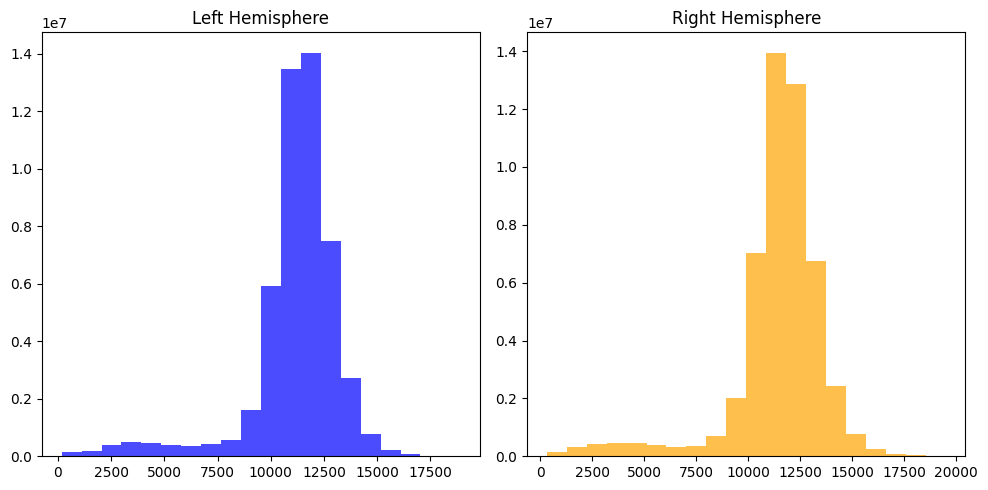

In [10]:
# Flatten the array of the first subject
flattened_lh = lh_bold.flatten()
flattened_rh = rh_bold.flatten()

# Plot histogram of BOLD values to get max and min
plt.figure(figsize=(10, 5))  # Adjust figure size if needed

plt.subplot(1, 2, 1)
plt.hist(flattened_lh, bins=20, color='blue', alpha=0.7)
plt.title('Left Hemisphere')

plt.subplot(1, 2, 2)
plt.hist(flattened_rh, bins=20, color='orange', alpha=0.7)
plt.title('Right Hemisphere')

plt.tight_layout()
plt.show()

In [11]:
def sub_channel(lh_data, rh_data):
    (fig, axs) = plt.subplots(2, 2, figsize=(2,2), dpi=72*4)
    ny.cortex_plot(lh_fmap_front, axes=axs[0,0], color=lh_data[lh_fmap_front.labels], cmap='gray',
                   vmin = 0, vmax = 17500)
    ny.cortex_plot(lh_fmap_back, axes=axs[1,0], color=lh_data[lh_fmap_back.labels], cmap='gray',
                   vmin = 0, vmax = 17500)
    ny.cortex_plot(rh_fmap_front, axes=axs[0,1], color=rh_data[rh_fmap_front.labels], cmap='gray',
                   vmin = 0, vmax = 17500)
    ny.cortex_plot(rh_fmap_back, axes=axs[1,1], color=rh_data[rh_fmap_back.labels], cmap='gray',
                   vmin = 0, vmax = 17500)
    fig.subplots_adjust(0,0,1,1,0,0)
    for ax in axs.flatten():
        ax.axis('off')
    return fig

# vmin and vmax options shoudl include bulk of BOLD values. 
# take image matrices and flatten and plot as histogram

In [22]:
import os

subj_id = []
path = '/home/jovyan/shared/HCP/'

# Specify the path for a new train/validation set directory
train_dir = './train'
val_dir = './val'
gray_img = './gray_img' # initially stores all the unclassified images

# Specify paths for the class directories
social_dir_train = './train/social/'
social_dir_val = './val/social/'
nonsoc_dir_train = './train/non-social/'
nonsoc_dir_val = './val/non-social/'

# Create the directories
os.makedirs(train_dir, exist_ok = True)
os.makedirs(val_dir, exist_ok = True)
os.makedirs(gray_img, exist_ok = True)
os.makedirs(social_dir_train, exist_ok = True)
os.makedirs(social_dir_val, exist_ok = True)
os.makedirs(nonsoc_dir_train, exist_ok = True)
os.makedirs(nonsoc_dir_val, exist_ok = True)

# Check if the directory was created
if os.path.exists(nonsoc_dir_val):
    print(f"Directory '{nonsoc_dir_val}' created successfully.")
else:
    print(f"Failed to create directory '{nonsoc_dir_val}'.")
    
# Scrape HCP folder for subject IDs. Outputs a list of subject IDs
for dir in os.listdir(path):
    parts = dir.split('.')
    subj_id.append(parts[0])
    
# using list comprehension + enumerate() to remove duplicated from list
subj_id = [i for n, i in enumerate(subj_id) if i not in subj_id[:n]]
print(subj_id)

Directory './val/non-social/' created successfully.
['115825']


In [ ]:
import skimage as sp
from PIL import Image

chunk_size = 5
img_matrices = []

for sid in subj_id:
    filename = path + sid + '/MNINonLinear/Results/tfMRI_MOVIE2_7T_PA/tfMRI_MOVIE2_7T_PA_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
    cii = ny.load(filename)
    (lh_bold, rh_bold, subcortex_bold) = ny.hcp.cifti_split(cii)
    tr = lh_bold.shape[0]
    
    #initializes matrices of BOLD values across lh/rh vertices (columns) averaged over every 5 TRs (rows)
    lh_bold_new = [] 
    rh_bold_new = []
    
    # averages over every 5s (1 TR = 1s)
    for i in range(0, tr, chunk_size): 
        lh_chunk = lh_bold[i:i+chunk_size, :]
        lh_chunk_mean = np.mean(lh_chunk, axis=0)
        lh_bold_new.append(lh_chunk_mean)
        rh_chunk = rh_bold[i:i+chunk_size, :]
        rh_chunk_mean = np.mean(rh_chunk, axis=0)
        rh_bold_new.append(rh_chunk_mean)
    # now we have a matrix per hemi and per subject with BOLD averaged into 5s intervals
    # don't need to account for inter/intra-individual variability with CNNs;
    # thus treat each row as a separate obs
        
    # create images for each of the 5s slices
    for t in range(len(lh_bold_new)): 
        avg_img = sub_channel(lh_bold_new[t], rh_bold_new[t])
        plt.savefig(str(sid) + '_' + str(t) + '.png', dpi = 125)
        
        # Open the RGBA image
        image_path = str(sid) + '_' + str(t) + '.png'
        rgba_image = Image.open(image_path)

        # Convert the RGBA image to grayscale
        grayscale_image = rgba_image.convert('L')

        # Save the grayscale image
        output_path = './gray_img/' + str(sid) + '_' + str(t) + '_gs.png'
        grayscale_image.save(output_path)
        
        im_mtx = sp.io.imread(output_path)
        print("shape of image matrix " + str(t) + ": ", im_mtx.shape)
        img_matrices.append(im_mtx)
        
stacked_matrix = np.stack(img_matrices, axis=2)
print("Shape of the stacked matrix:", stacked_matrix.shape)
#        ny.save.nifti(filename)
#        ny.load(image_array)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


shape of image matrix 0:  (250, 250)
shape of image matrix 1:  (250, 250)
shape of image matrix 2:  (250, 250)
shape of image matrix 3:  (250, 250)
shape of image matrix 4:  (250, 250)
shape of image matrix 5:  (250, 250)
shape of image matrix 6:  (250, 250)
shape of image matrix 7:  (250, 250)
shape of image matrix 8:  (250, 250)
shape of image matrix 9:  (250, 250)
shape of image matrix 10:  (250, 250)
shape of image matrix 11:  (250, 250)
shape of image matrix 12:  (250, 250)
shape of image matrix 13:  (250, 250)
shape of image matrix 14:  (250, 250)
shape of image matrix 15:  (250, 250)
shape of image matrix 16:  (250, 250)
shape of image matrix 17:  (250, 250)
shape of image matrix 18:  (250, 250)
shape of image matrix 19:  (250, 250)


/tmp/ipykernel_269/3384361773.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  (fig, axs) = plt.subplots(2, 2, figsize=(2,2), dpi=72*4)


shape of image matrix 20:  (250, 250)
shape of image matrix 21:  (250, 250)
shape of image matrix 22:  (250, 250)
shape of image matrix 23:  (250, 250)
shape of image matrix 24:  (250, 250)
shape of image matrix 25:  (250, 250)
shape of image matrix 26:  (250, 250)
shape of image matrix 27:  (250, 250)
shape of image matrix 28:  (250, 250)
shape of image matrix 29:  (250, 250)
shape of image matrix 30:  (250, 250)
shape of image matrix 31:  (250, 250)
shape of image matrix 32:  (250, 250)
shape of image matrix 33:  (250, 250)
shape of image matrix 34:  (250, 250)
shape of image matrix 35:  (250, 250)
shape of image matrix 36:  (250, 250)
shape of image matrix 37:  (250, 250)
shape of image matrix 38:  (250, 250)
shape of image matrix 39:  (250, 250)
shape of image matrix 40:  (250, 250)
shape of image matrix 41:  (250, 250)
shape of image matrix 42:  (250, 250)
shape of image matrix 43:  (250, 250)
shape of image matrix 44:  (250, 250)
shape of image matrix 45:  (250, 250)
shape of ima

In [ ]:
# create a simulated classification tensor 
# of length 54 because that's how many images were created before the kernel broke

import random

vector_length = 54 # could set this to length t
random_seed = 42

# Set the random seed
random.seed(random_seed)

# Generate a random vector with random placements of 1's and 0's
random_vector = [random.choice([0, 1]) for _ in range(vector_length)]

print(table(random_vector))

In [12]:
# import the actual classification tensor - social vs non-social scenes up to 54*5s = 270s
import pandas as pd
import numpy as np

# Specify the path to the CSV file
csv_file_path = './hcp_movie2_face_detection.csv'

# Read the CSV file into a pandas DataFrame
class_vector = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(class_vector.head())

# Calculate the mean for every 5 rows
grouped_cv = class_vector.groupby(class_vector.index // 5).mean()

# Isolate the 2nd column indicating presence of social interaction
second_column = grouped_cv.iloc[:, 1]

# Convert the selected column to a NumPy array
cv = second_column.to_numpy()

# Replace nonzero values with 1 (0 = no social interaction, 1 = social interaction)
cv[cv != 0] = 1

# Display the resulting modified class vector
print(cv)
print(len(cv))

# Count the occurrences of 1s and 0s
num_ones = np.sum(cv == 1)
num_zeros = np.sum(cv == 0)

# Calculate proportions
total_elements = len(cv)
proportion_ones = num_ones / total_elements
proportion_zeros = num_zeros / total_elements

print(f"Proportion of 1s: {proportion_ones:.2f}")
print(f"Proportion of 0s: {proportion_zeros:.2f}")

   1  0
0  2  0
1  3  0
2  4  0
3  5  0
4  6  0
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 0.]
54
Proportion of 1s: 0.37
Proportion of 0s: 0.63


In [15]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Specify the source directory containing all images
source_directory = './gray_img'

# Specify paths for the class directories
social_dir_train = './train/social/'
social_dir_val = './val/social/'
nonsoc_dir_train = './train/non-social/'
nonsoc_dir_val = './val/non-social/'

# List all image filenames in the source directory
image_filenames = os.listdir(source_directory)

# Split filenames into train and validation sets
train_filenames, validation_filenames = train_test_split(image_filenames, test_size=0.3, random_state=42)

# Move train images to the train directory
for filename in train_filenames:
    source_path = os.path.join(source_directory, filename)
    name_parts = filename.split('_')
    for index, value in enumerate(cv):
        if index == int(name_parts[1]):
            if value == 1:
                destination_path = os.path.join(social_dir_train, filename)
            elif value == 0:
                destination_path = os.path.join(nonsoc_dir_train, filename)
            shutil.move(source_path, destination_path)

# Move validation images to the validation directory
for filename in validation_filenames:
    source_path = os.path.join(source_directory, filename)
    name_parts = filename.split('_')
    for index, value in enumerate(cv):
        if index == int(name_parts[1]):
            if value == 1:
                destination_path = os.path.join(social_dir_val, filename)
            elif value == 0:
                destination_path = os.path.join(nonsoc_dir_val, filename)
            shutil.move(source_path, destination_path)

In [17]:
print(train_filenames)

['115825_5_gs.png', '115825_9_gs.png', '115825_54_gs.png']
